In [1]:
from utilities import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
import pymc as pm
import aesara.tensor as at
import multiprocessing
#from create_training_instance_dictionary_with_covariates import *
#from feature_extraction import *
#from sample_from_full_model import *
from BNN_model import *
# Initialize random number generator
RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)
print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v4.2.2


In [2]:
# Settings
true_sigma_obs = 0.5
N_patients = 150
P = 3 # Number of covariates
P0 = int(P / 2) # A guess of the true number of nonzero parameters is needed for defining the global shrinkage parameter
true_omega = np.array([0.05, 0.10, 0.15])
M_number_of_measurements = 5
days_between_measurements = int(1500/M_number_of_measurements)
measurement_times = days_between_measurements * np.linspace(0, M_number_of_measurements-1, M_number_of_measurements)
treatment_history = np.array([Treatment(start=0, end=measurement_times[-1], id=1)])
true_omega_for_psi = 0.1
RANDOM_EFFECTS=True

# Function to get expected theta from X
def get_expected_theta_from_X_one_interaction(X): # One interaction: In rho_s only
    # These are the true parameters for a patient with all covariates equal to 0:
    N_patients_local, _ = X.shape
    rho_s_population = -0.005
    rho_r_population = 0.001
    pi_r_population = 0.4
    theta_rho_s_population_for_x_equal_to_zero = np.log(-rho_s_population)
    theta_rho_r_population_for_x_equal_to_zero = np.log(rho_r_population)
    theta_pi_r_population_for_x_equal_to_zero  = np.log(pi_r_population/(1-pi_r_population))

    true_alpha = np.array([theta_rho_s_population_for_x_equal_to_zero, theta_rho_r_population_for_x_equal_to_zero, theta_pi_r_population_for_x_equal_to_zero])
    true_beta_rho_s = np.zeros(P)
    true_beta_rho_s[0] = 0.8
    true_beta_rho_s[1] = 0
    interaction_beta_x1_x2_rho_s = -1
    true_beta_rho_r = np.zeros(P)
    true_beta_rho_r[0] = 0.7
    true_beta_rho_r[1] = 1.0
    true_beta_pi_r = np.zeros(P)
    true_beta_pi_r[0] = 0.0
    true_beta_pi_r[1] = 1.1

    expected_theta_1 = np.reshape(true_alpha[0] + np.dot(X, true_beta_rho_s) + np.ravel(interaction_beta_x1_x2_rho_s*X["Covariate 1"]*(X["Covariate 2"].T)), (N_patients_local,1))
    expected_theta_2 = np.reshape(true_alpha[1] + np.dot(X, true_beta_rho_r), (N_patients_local,1))
    expected_theta_3 = np.reshape(true_alpha[2] + np.dot(X, true_beta_pi_r), (N_patients_local,1))
    return expected_theta_1, expected_theta_2, expected_theta_3

def get_expected_theta_from_X_2(X): # One interaction: In rho_s only
    N_patients_local, _ = X.shape
    # These are the true parameters for a patient with all covariates equal to 0:
    rho_s_population = -0.005
    rho_r_population = 0.001
    pi_r_population = 0.4
    theta_rho_s_population_for_x_equal_to_zero = np.log(-rho_s_population)
    theta_rho_r_population_for_x_equal_to_zero = np.log(rho_r_population)
    theta_pi_r_population_for_x_equal_to_zero  = np.log(pi_r_population/(1-pi_r_population))

    true_alpha = np.array([theta_rho_s_population_for_x_equal_to_zero, theta_rho_r_population_for_x_equal_to_zero, theta_pi_r_population_for_x_equal_to_zero])
    true_beta_rho_s = np.zeros(P)
    true_beta_rho_s[0] = 0.8
    true_beta_rho_s[1] = 0
    interaction_beta_x1_x2_rho_s = -1
    true_beta_rho_r = np.zeros(P)
    true_beta_rho_r[0] = 0.7
    true_beta_rho_r[1] = 1.0
    true_beta_pi_r = np.zeros(P)
    true_beta_pi_r[0] = 0.0
    true_beta_pi_r[1] = 1.1
    interaction_beta_x2_x3_pi_r = -0.6

    expected_theta_1 = np.reshape(true_alpha[0] + np.dot(X, true_beta_rho_s) + np.ravel(interaction_beta_x1_x2_rho_s*X["Covariate 1"]*(X["Covariate 2"].T)), (N_patients_local,1))
    expected_theta_2 = np.reshape(true_alpha[1] + np.dot(X, true_beta_rho_r), (N_patients_local,1))
    expected_theta_3 = np.reshape(true_alpha[2] + np.dot(X, true_beta_pi_r)  + np.ravel(interaction_beta_x2_x3_pi_r*X["Covariate 2"]*(X["Covariate 3"].T)), (N_patients_local,1))
    return expected_theta_1, expected_theta_2, expected_theta_3

X, patient_dictionary, parameter_dictionary, expected_theta_1, true_theta_rho_s, true_rho_s = generate_simulated_patients(measurement_times, treatment_history, true_sigma_obs, N_patients, P, get_expected_theta_from_X_2, true_omega, true_omega_for_psi, seed=42, RANDOM_EFFECTS=RANDOM_EFFECTS)

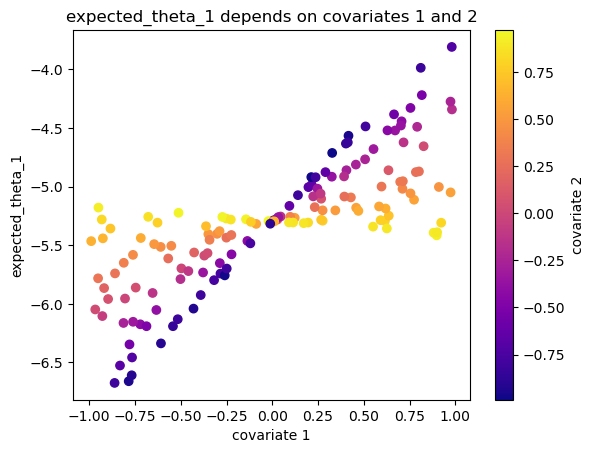

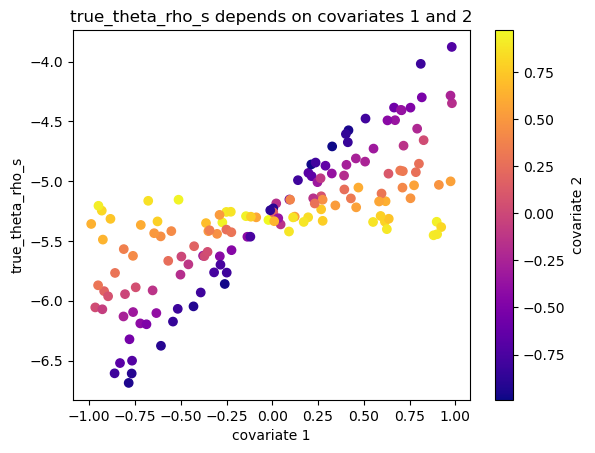

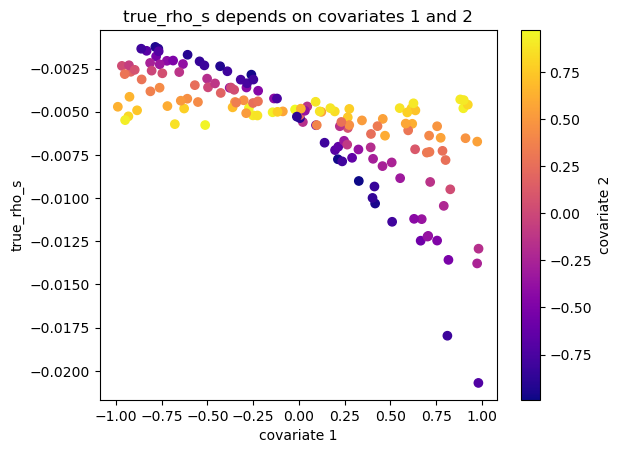

In [3]:
# Visualize parameter dependancy on covariates 
VISZ = True
if VISZ:
    color_array = X["Covariate 2"].to_numpy()

    fig, ax = plt.subplots()
    ax.set_title("expected_theta_1 depends on covariates 1 and 2")
    points = ax.scatter(X["Covariate 1"], expected_theta_1, c=color_array, cmap="plasma")
    ax.set_xlabel("covariate 1")
    ax.set_ylabel("expected_theta_1")
    cbar = fig.colorbar(points)
    cbar.set_label('covariate 2', rotation=90)
    plt.show()

    fig, ax = plt.subplots()
    ax.set_title("true_theta_rho_s depends on covariates 1 and 2")
    points = ax.scatter(X["Covariate 1"], true_theta_rho_s, c=color_array, cmap="plasma")
    ax.set_xlabel("covariate 1")
    ax.set_ylabel("true_theta_rho_s")
    cbar = fig.colorbar(points)
    cbar.set_label('covariate 2', rotation=90)
    plt.show()

    fig, ax = plt.subplots()
    ax.set_title("true_rho_s depends on covariates 1 and 2")
    points = ax.scatter(X["Covariate 1"], true_rho_s, c=color_array, cmap="plasma")
    ax.set_xlabel("covariate 1")
    ax.set_ylabel("true_rho_s")
    cbar = fig.colorbar(points)
    cbar.set_label('covariate 2', rotation=90)
    plt.show()

In [4]:
## Transpose and check that dimensions are correct
#Y = np.transpose(np.array([patient.Mprotein_values for _, patient in patient_dictionary.items()]))
#t = np.transpose(np.array([patient.measurement_times for _, patient in patient_dictionary.items()]))
#yi0 = np.array([patient.Mprotein_values[0] for _, patient in patient_dictionary.items()])
#yi0 = np.maximum(yi0, 1e-5)
##print("Y:\n", Y)
##print("t:\n", t)
##print("yi0:\n", yi0)
##print("X:\n", X)
#X_not_transformed = X.copy().T
#print(X_not_transformed.columns.values)
##X = X.T
#print("Shapes:")
#print("Y:", Y.shape)
#print("t:", t.shape)
#print("yi0:", yi0.shape)
#print("X:", X.shape)
#print("Done generating data")
#
#assert X.shape[0] == len(patient_dictionary)
#N_cases, P = X.shape
#print("N_cases:", N_cases)
#print(patient_dictionary[0].treatment_history[-1].end)

Running simdata_BNN_M_5_P_3_N_patients_150_psi_prior_lognormal_N_samples_10_N_tuning_10_target_accept_0.99_max_treedepth_10_FUNNEL_REPARAMETRIZATION_False


/home/evenmm/anaconda3/envs/second_pymc_env/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/evenmm/anaconda3/envs/second_pymc_env/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
Sampling: [Y_obs, alpha, bias_in_pi_r, bias_in_rho_r, bias_in_rho_s, bias_out_pi_r, bias_out_rho_r, bias_out_rho_s, log_psi, omega, sigma_bias_in, sigma_bias_out, sigma_obs, sigma_weights_in, sigma_weights_out, theta_pi_r, theta_rho

Convergence achieved at 135000
Interrupted at 134,999 [67%]: Average Loss = 1.0816e+159
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_obs, alpha, sigma_weights_in, sigma_weights_out, weights_in_rho_s, weights_in_rho_r, weights_in_pi_r, weights_out_rho_s, weights_out_rho_r, weights_out_pi_r, sigma_bias_in, bias_in_rho_s, bias_in_rho_r, bias_in_pi_r, sigma_bias_out, bias_out_rho_s, bias_out_rho_r, bias_out_pi_r, omega, theta_rho_s, theta_rho_r, theta_pi_r, xi, log_psi]


Sampling 4 chains for 10 tune and 10 draw iterations (40 + 40 draws total) took 49 seconds.
The acceptance probability does not match the target. It is 0.6865, but should be close to 0.99. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The acceptance probability does not match the target. It is 0.8917, but should be close to 0.99. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The acceptance probability does not match the target. It is 0.8506, but should be close to 0.99. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.


Done sampling


/tmp/ipykernel_26561/2176768651.py:16: UserWarning: The number of samples is too small to check convergence reliably.
  idata = pm.sample(draws=N_samples, tune=N_tuning, init="advi+adapt_diag", random_seed=42, target_accept=target_accept, max_treedepth=max_treedepth)


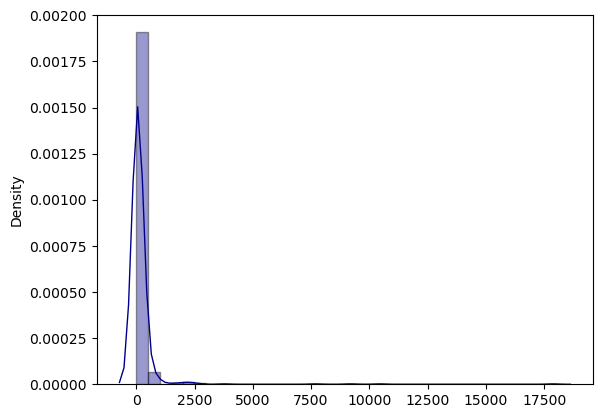

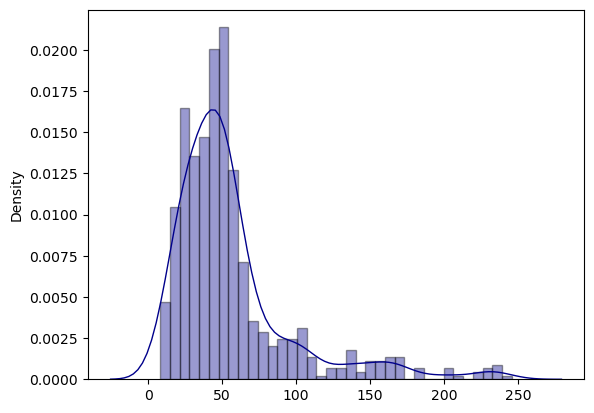

In [5]:
# Sample from full model
psi_prior="lognormal"
WEIGHT_PRIOR = "symmetry_fix" #"iso_normal"
N_samples = 10
N_tuning = 10
target_accept = 0.99
max_treedepth = 10
FUNNEL_REPARAMETRIZATION = False
MODEL_RANDOM_EFFECTS = True
name = "simdata_BNN_M_"+str(M_number_of_measurements)+"_P_"+str(P)+"_N_patients_"+str(N_patients)+"_psi_prior_"+psi_prior+"_N_samples_"+str(N_samples)+"_N_tuning_"+str(N_tuning)+"_target_accept_"+str(target_accept)+"_max_treedepth_"+str(max_treedepth)+"_FUNNEL_REPARAMETRIZATION_"+str(FUNNEL_REPARAMETRIZATION)
print("Running "+name)
neural_net_model = BNN_model(X, patient_dictionary, name, psi_prior=psi_prior, MODEL_RANDOM_EFFECTS=MODEL_RANDOM_EFFECTS, FUNNEL_REPARAMETRIZATION=FUNNEL_REPARAMETRIZATION, WEIGHT_PRIOR=WEIGHT_PRIOR)
# Draw samples from posterior:
with neural_net_model:
    # HMC 
    idata = pm.sample(draws=N_samples, tune=N_tuning, init="advi+adapt_diag", random_seed=42, target_accept=target_accept, max_treedepth=max_treedepth)

# This is an xArray: https://docs.xarray.dev/en/v2022.11.0/user-guide/data-structures.html
print("Done sampling")

In [6]:
# Convergence checks
def quasi_geweke_test(idata, first=0.1, last=0.5, intervals=20):
    print("Running Geweke test...")
    convergence_flag = True
    for var_name in ['alpha', 'omega', 'theta_rho_s', 'theta_rho_r', 'theta_pi_r', 'rho_s', 'rho_r', 'pi_r']:
        sample_shape = idata.posterior[var_name].shape
        n_chains = sample_shape[0]
        n_samples = sample_shape[1]
        var_dims = sample_shape[2]
        for chain in range(n_chains):
            for dim in range(var_dims):
                all_samples = np.ravel(idata.posterior[var_name][chain,:,dim])
                first_part = all_samples[0:int(n_samples*first)]
                last_part = all_samples[n_samples-int(n_samples*last):n_samples]
                z_score = (np.mean(first_part)-np.mean(last_part)) / np.sqrt(np.var(first_part)+np.var(last_part))
                if abs(z_score) >= 1.960:
                    convergence_flag = False
                    print("Seems like chain",chain,"has not converged in",var_name,"dimension",dim,": z_score is",z_score)
    for var_name in ['sigma_obs']:
        all_samples = np.ravel(idata.posterior[var_name])
        n_samples = len(all_samples)
        first_part = all_samples[0:int(n_samples*first)]
        last_part = all_samples[n_samples-int(n_samples*last):n_samples]
        z_score = (np.mean(first_part)-np.mean(last_part)) / np.sqrt(np.var(first_part)+np.var(last_part))
        if abs(z_score) >= 1.960:
            convergence_flag = False
            print("Seems like chain",chain,"has not converged in",var_name,"dimension",dim,": z_score is",z_score)
    if convergence_flag:
        print("All chains seem to have converged.")
    return 0

quasi_geweke_test(idata, first=0.1, last=0.5)

Running Geweke test...
Seems like chain 1 has not converged in alpha dimension 0 : z_score is 4.885177601071718
Seems like chain 1 has not converged in alpha dimension 2 : z_score is -3.2696768051851346
Seems like chain 2 has not converged in alpha dimension 0 : z_score is -3.010126493433828
Seems like chain 2 has not converged in alpha dimension 2 : z_score is 2.550213379419478
Seems like chain 3 has not converged in alpha dimension 0 : z_score is -2.9864666311965067
Seems like chain 3 has not converged in alpha dimension 1 : z_score is -2.667472914104117
Seems like chain 3 has not converged in alpha dimension 2 : z_score is -6.210340618576244
Seems like chain 0 has not converged in omega dimension 0 : z_score is 17.32324288898364
Seems like chain 0 has not converged in omega dimension 2 : z_score is 3.321396662437703
Seems like chain 1 has not converged in omega dimension 0 : z_score is 7.695623701149118
Seems like chain 1 has not converged in omega dimension 1 : z_score is 2.0480730

0

array([<AxesSubplot: title={'center': 'sigma_obs\n0'}>,
       <AxesSubplot: title={'center': 'sigma_obs\n1'}>,
       <AxesSubplot: title={'center': 'sigma_obs\n2'}>,
       <AxesSubplot: title={'center': 'sigma_obs\n3'}>], dtype=object)

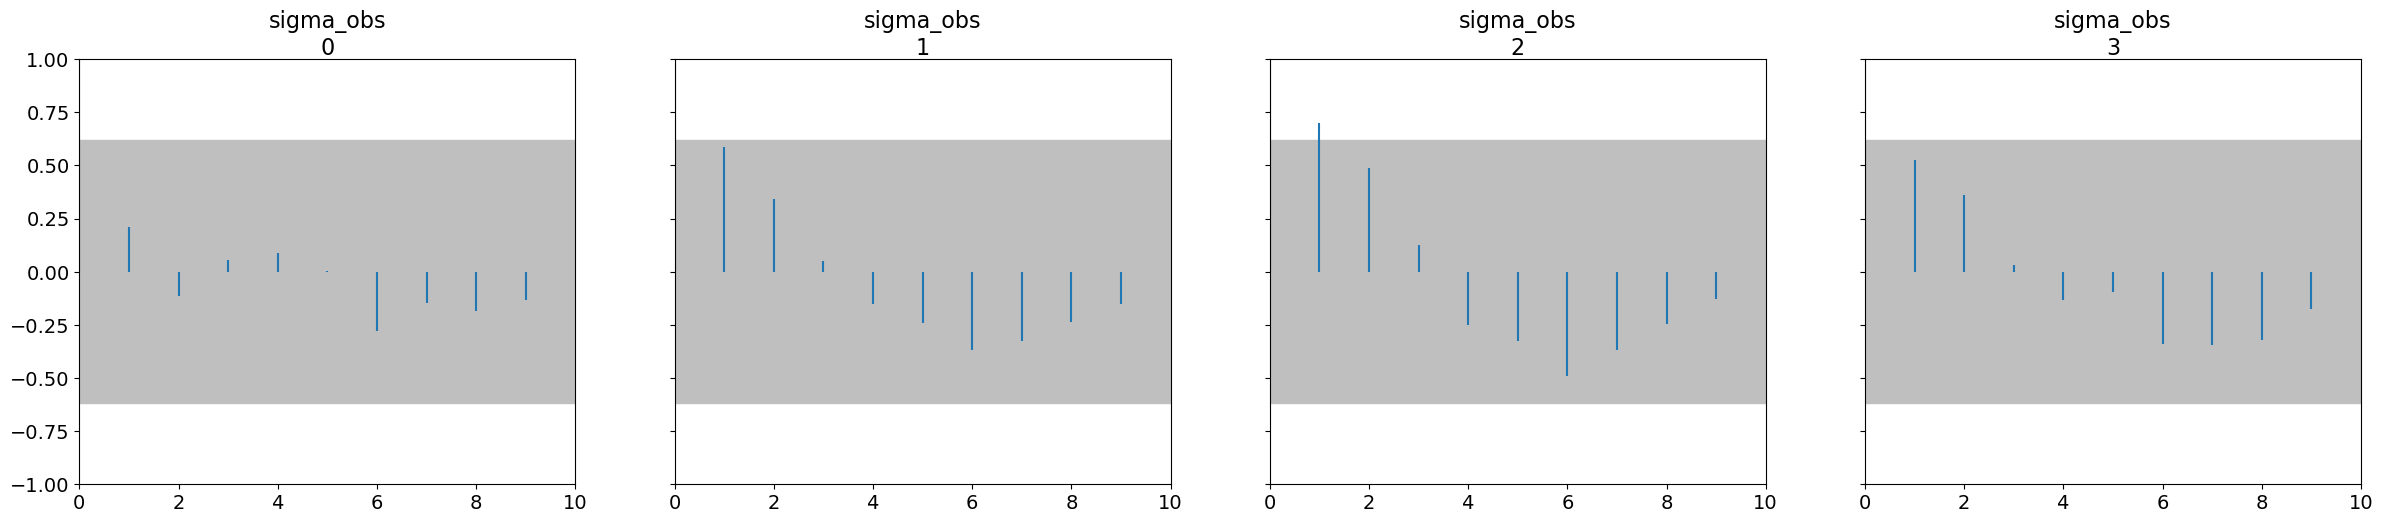

In [7]:
# Autocorrelation plots: 
az.plot_autocorr(idata, var_names=["sigma_obs"])
#az.plot_autocorr(idata, var_names=["alpha"]);
#az.plot_autocorr(idata, var_names=["omega"]);

In [8]:
# Posterior means 
#print('Posterior average of alpha:\n', np.mean(idata.posterior['alpha'], axis=(0,1)))
#print('\nPosterior average of omega:\n', np.mean(idata.posterior['omega'], axis=(0,1)))
#print('\nPosterior average of sigma_obs:\n', np.mean(idata.posterior['sigma_obs'], axis=(0,1)))

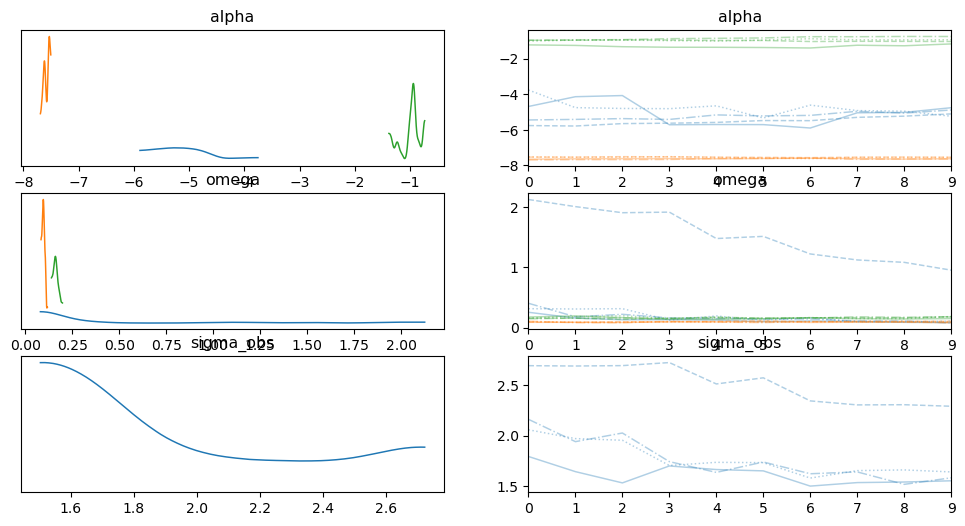

In [9]:
az.plot_trace(idata, var_names=('alpha', 'omega', 'sigma_obs'), combined=True)
plt.savefig("./plots/posterior_plots/"+name+"-plot_posterior_group_parameters.pdf")

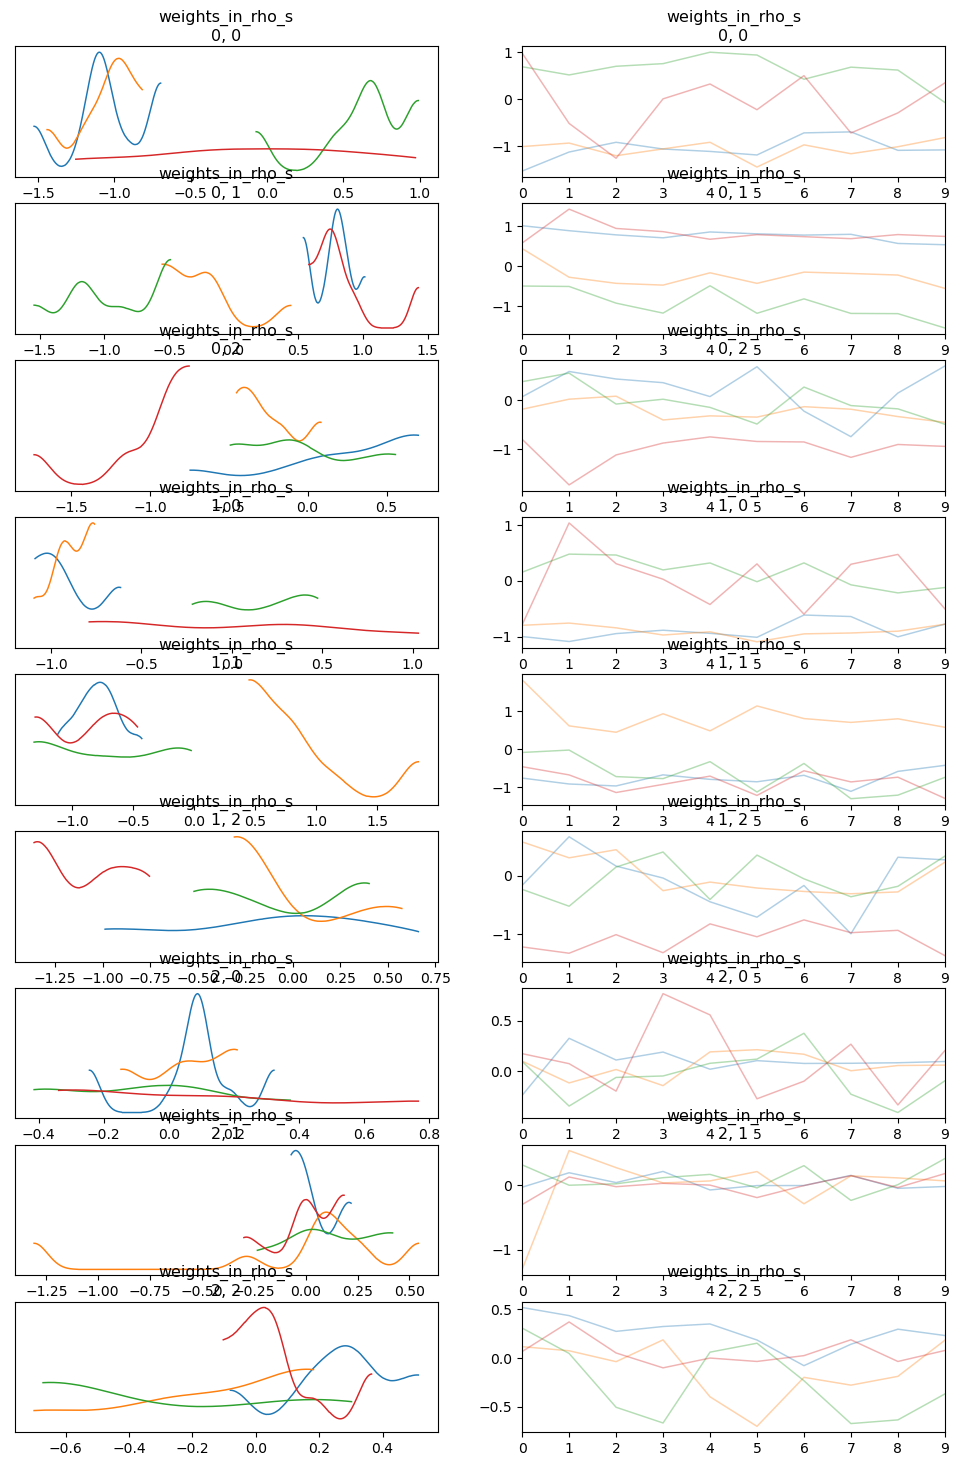

In [10]:
# Plot weights in_1 rho_s
# Combined means combine the chains into one posterior. Compact means split into different subplots
az.plot_trace(idata, var_names=('weights_in_rho_s'), combined=False, compact=False)
plt.savefig("./plots/posterior_plots/"+name+"-plot_posterior_uncompact_weights_in_1_rho_s.pdf")

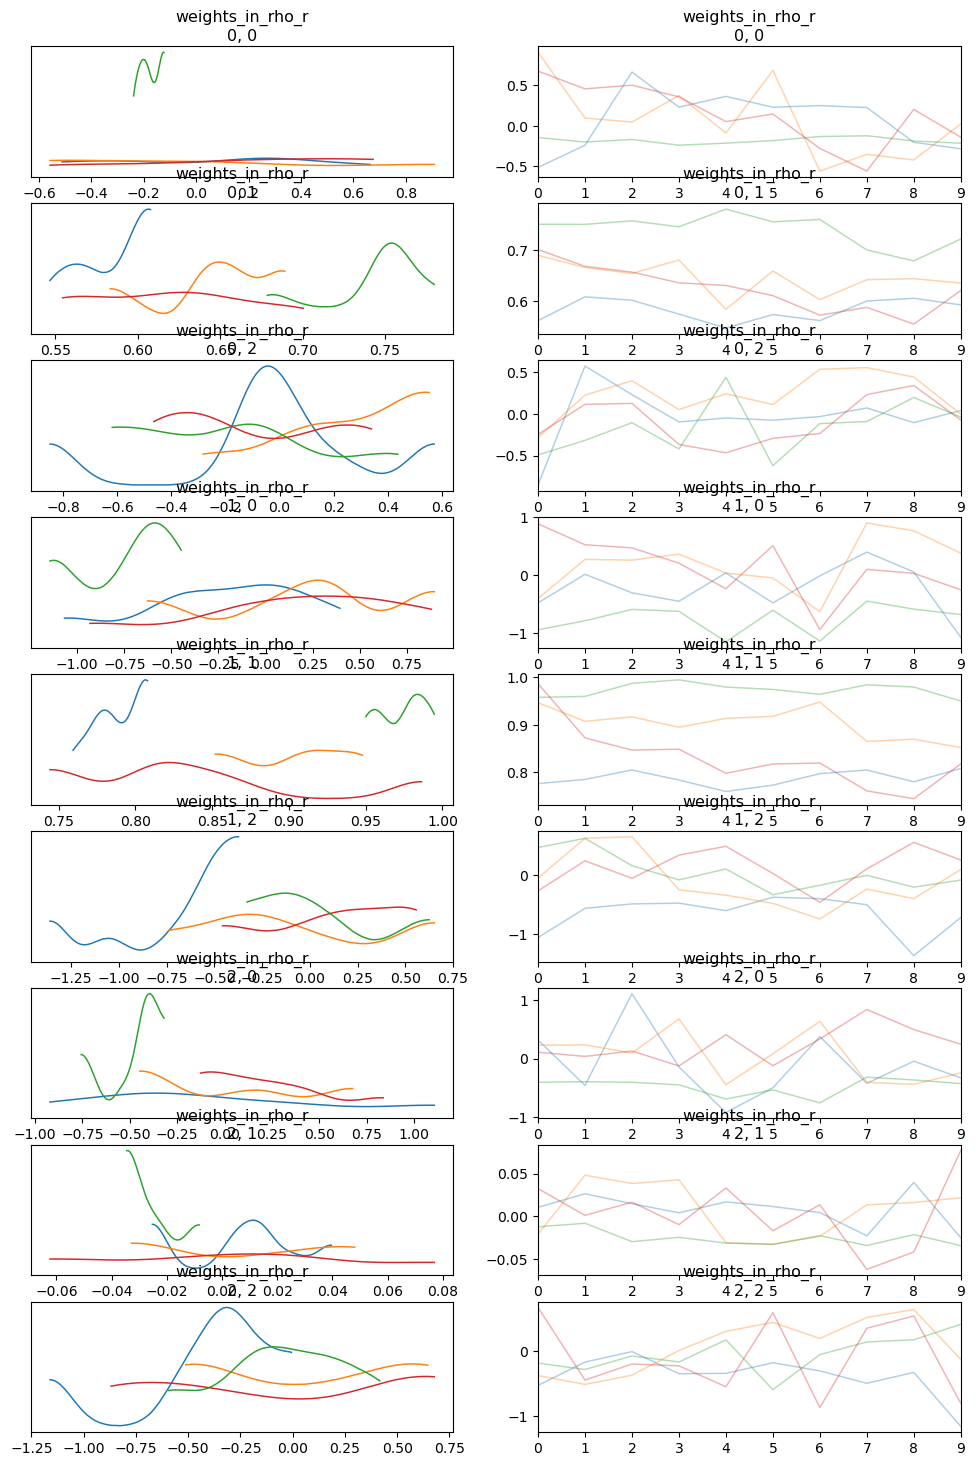

In [11]:
# Plot weights in_1 rho_r
# Combined means combine the chains into one posterior. Compact means split into different subplots
az.plot_trace(idata, var_names=('weights_in_rho_r'), combined=False, compact=False)
plt.savefig("./plots/posterior_plots/"+name+"-plot_posterior_uncompact_weights_in_1_rho_r.pdf")

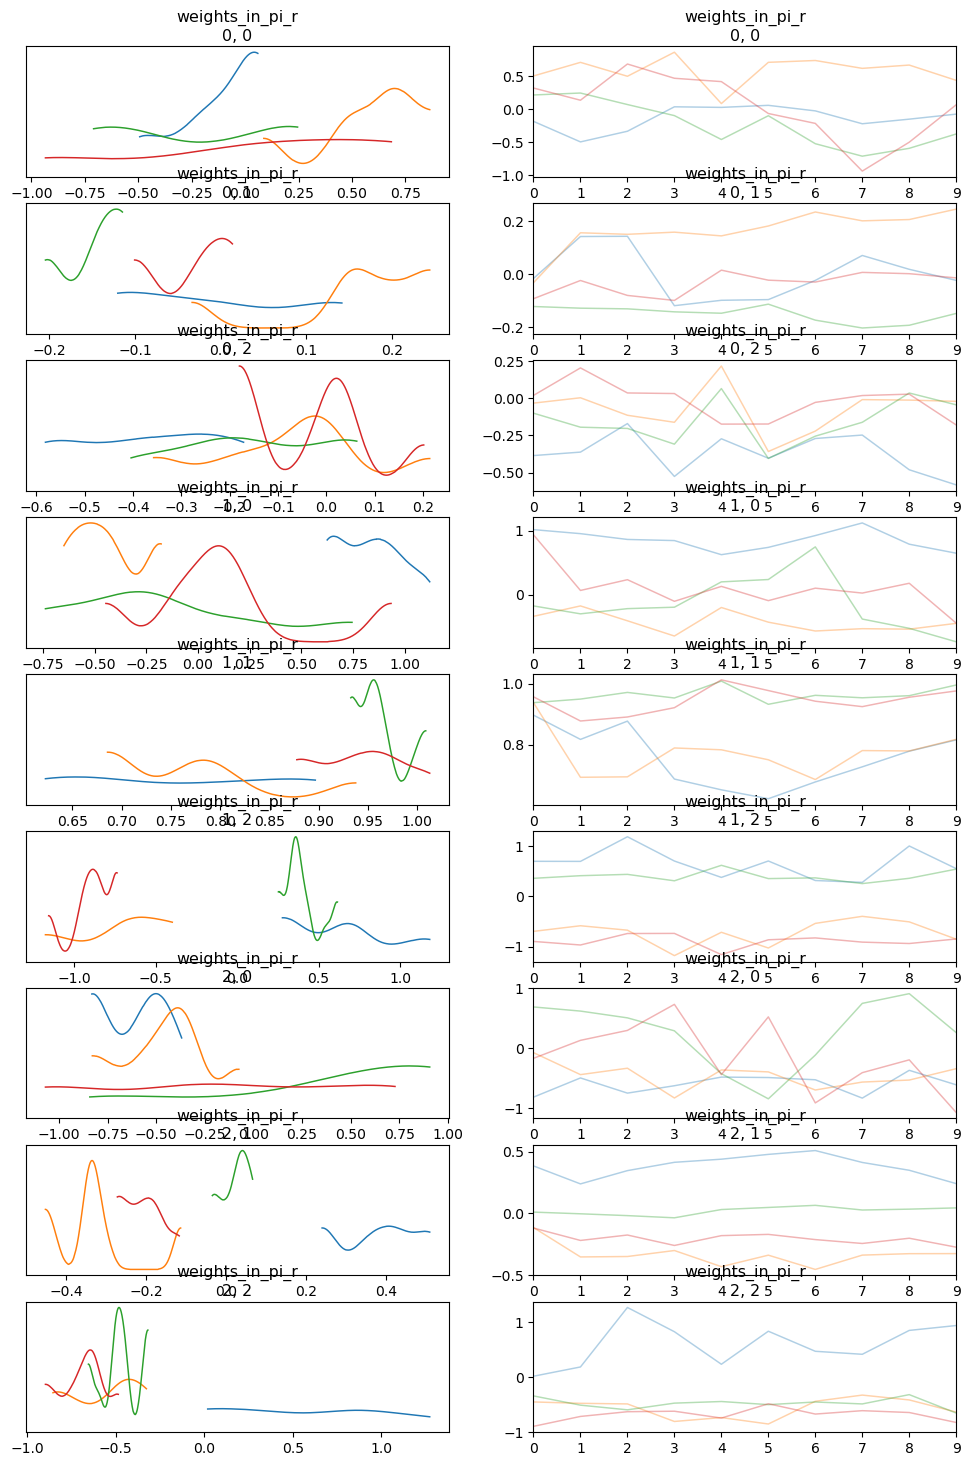

In [12]:
# Plot weights in_1 pi_r
# Combined means combine the chains into one posterior. Compact means split into different subplots
az.plot_trace(idata, var_names=('weights_in_pi_r'), combined=False, compact=False)
plt.savefig("./plots/posterior_plots/"+name+"-plot_posterior_uncompact_weights_in_1_pi_r.pdf")

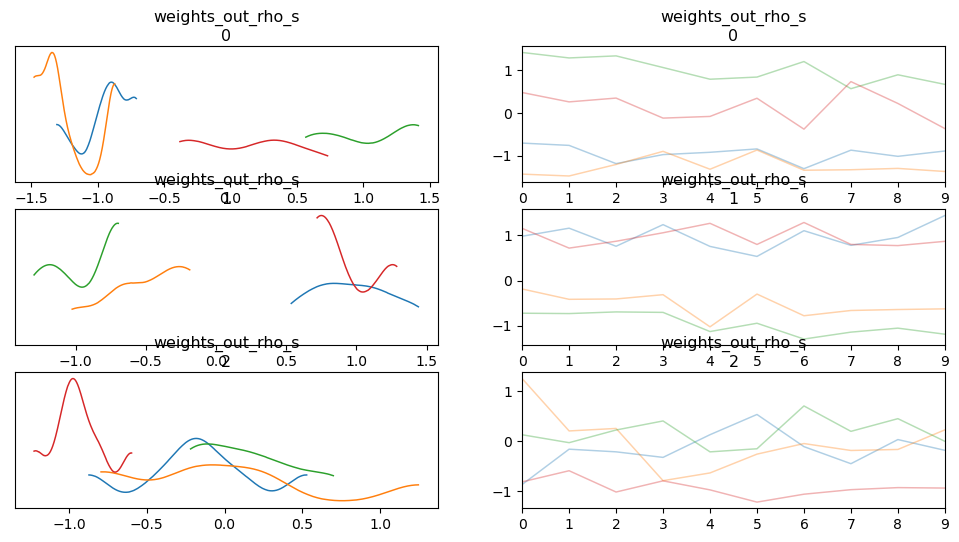

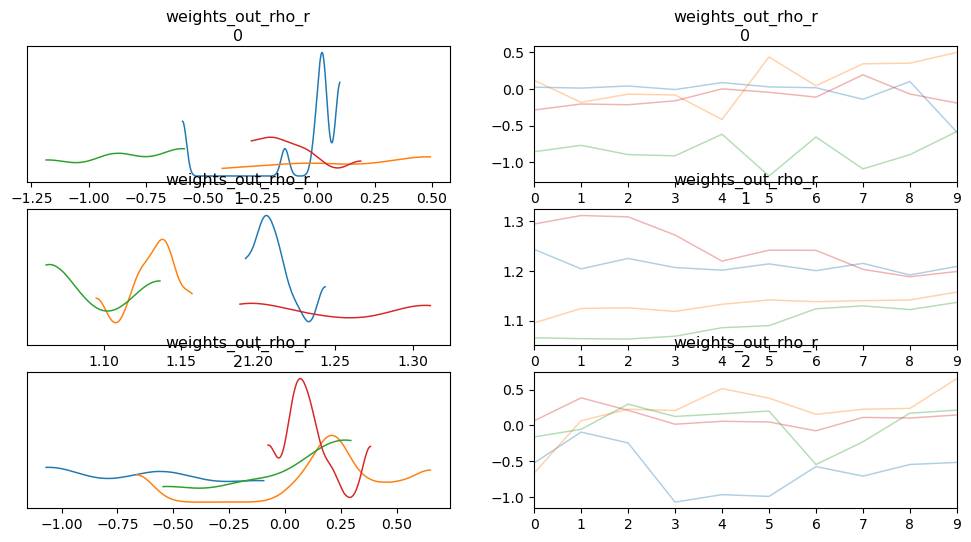

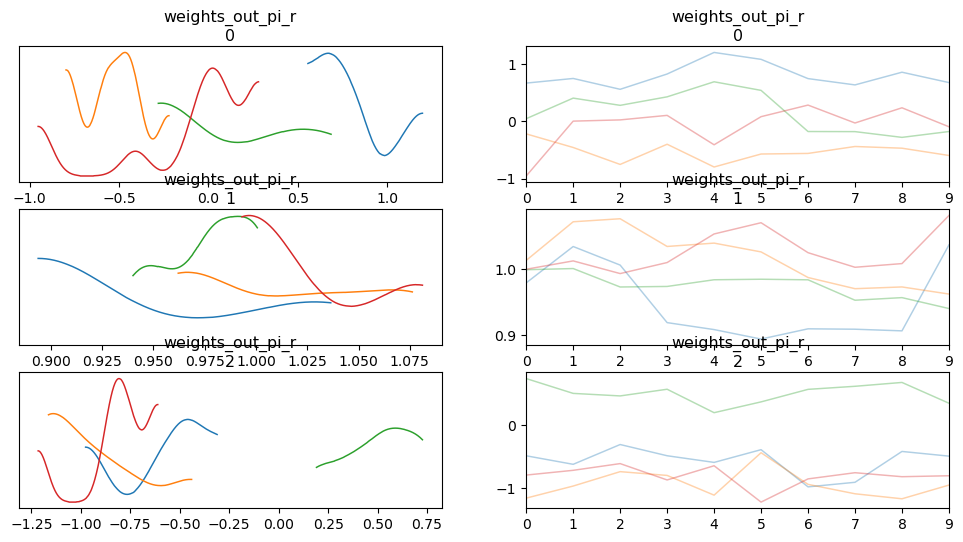

In [13]:
# Plot weights 2_out rho_s
# Combined means combine the chains into one posterior. Compact means split into different subplots
az.plot_trace(idata, var_names=('weights_out_rho_s'), combined=False, compact=False)
plt.savefig("./plots/posterior_plots/"+name+"-plot_posterior_uncompact_weights_out_rho_s.pdf")
# There is also an effect where there are less resistant cells for the older patients.

# Plot weights 2_out rho_r
# Combined means combine the chains into one posterior. Compact means split into different subplots
az.plot_trace(idata, var_names=('weights_out_rho_r'), combined=False, compact=False)
plt.savefig("./plots/posterior_plots/"+name+"-plot_posterior_uncompact_weights_out_rho_r.pdf")
# There is also an effect where there are less resistant cells for the older patients.

# Plot weights 2_out pi_r
# Combined means combine the chains into one posterior. Compact means split into different subplots
az.plot_trace(idata, var_names=('weights_out_pi_r'), combined=False, compact=False)
plt.savefig("./plots/posterior_plots/"+name+"-plot_posterior_uncompact_weights_out_pi_r.pdf")
# There is also an effect where there are less resistant cells for the older patients.


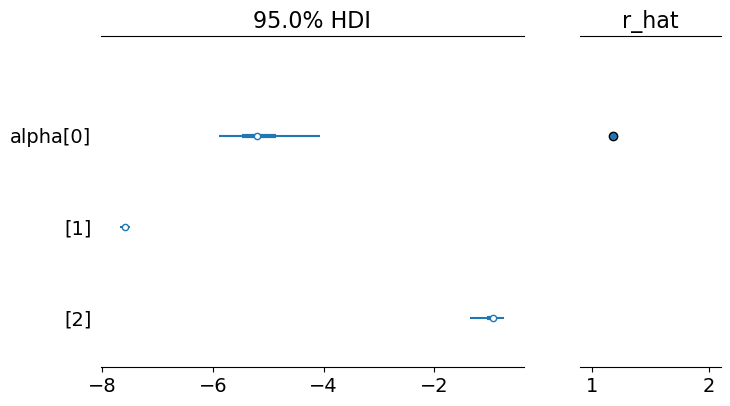

In [14]:
if psi_prior=="lognormal":
    az.plot_trace(idata, var_names=('xi'), combined=True)
    plt.savefig("./plots/posterior_plots/"+name+"-plot_posterior_group_parameters_xi.pdf")
    plt.close()
az.plot_trace(idata, var_names=('theta_rho_s', 'theta_rho_r', 'theta_pi_r', 'rho_s', 'rho_r', 'pi_r'), combined=True)
plt.savefig("./plots/posterior_plots/"+name+"-plot_posterior_individual_parameters.pdf")
plt.close()
# Test of exploration 
#az.plot_energy(idata)
#plt.savefig("./plots/posterior_plots/"+name+"-plot_energy.pdf")
#plt.close()
# Plot of coefficients
az.plot_forest(idata, var_names=["alpha"], combined=True, hdi_prob=0.95, r_hat=True)
plt.savefig("./plots/posterior_plots/"+name+"-plot_forest_alpha.pdf")
az.plot_forest(idata, var_names=["theta_rho_s"], combined=True, hdi_prob=0.95, r_hat=True)
plt.savefig("./plots/posterior_plots/"+name+"-plot_forest_theta_rho_s.pdf")
plt.close()
az.plot_forest(idata, var_names=["theta_rho_r"], combined=True, hdi_prob=0.95, r_hat=True)
plt.savefig("./plots/posterior_plots/"+name+"-plot_forest_theta_rho_r.pdf")
plt.close()
az.plot_forest(idata, var_names=["theta_pi_r"], combined=True, hdi_prob=0.95, r_hat=True)
plt.savefig("./plots/posterior_plots/"+name+"-plot_forest_theta_pi_r.pdf")
plt.close()

In [2]:
sample_shape = idata.posterior['psi'].shape # [chain, n_samples, dim]
n_chains = sample_shape[0]
n_samples = sample_shape[1]
var_dimensions = sample_shape[2] # one per patient
y_resolution = 80 # 1000 crashed the program

NameError: name 'idata' is not defined

In [32]:
# Posterior CI for train data
N_rand_obs_pred_train = 10000 # Number of observation noise samples to draw for each parameter sample
def plot_posterior_CI(args):
    sample_shape, y_resolution, ii = args
    n_chains = sample_shape[0]
    n_samples = sample_shape[1]
    var_dimensions = sample_shape[2] # one per patient
    np.random.seed(ii) # Seeding the randomness in observation noise sigma, in random effects and in psi = yi0 + random(sigma)

    patient = patient_dictionary[ii]
    measurement_times = patient.get_measurement_times() 
    treatment_history = patient.get_treatment_history()
    first_time = min(measurement_times[0], treatment_history[0].start)
    plotting_times = np.linspace(first_time, int(measurement_times[-1]), y_resolution) #int((measurement_times[-1]+1)*10))
    posterior_parameters = np.empty(shape=(n_chains, n_samples), dtype=object)
    predicted_y_values = np.empty(shape=(n_chains, n_samples*N_rand_obs_pred_train, y_resolution))
    predicted_y_resistant_values = np.empty_like(predicted_y_values)
    for ch in range(n_chains):
        for sa in range(n_samples):
            this_sigma_obs = np.ravel(idata.posterior['sigma_obs'][ch,sa])
            this_psi       = np.ravel(idata.posterior['psi'][ch,sa,ii])
            this_pi_r      = np.ravel(idata.posterior['pi_r'][ch,sa,ii])
            this_rho_s     = np.ravel(idata.posterior['rho_s'][ch,sa,ii])
            this_rho_r     = np.ravel(idata.posterior['rho_r'][ch,sa,ii])
            posterior_parameters[ch,sa] = Parameters(Y_0=this_psi, pi_r=this_pi_r, g_r=this_rho_r, g_s=this_rho_s, k_1=0, sigma=this_sigma_obs)
            these_parameters = posterior_parameters[ch,sa]
            resistant_parameters = Parameters((these_parameters.Y_0*these_parameters.pi_r), 1, these_parameters.g_r, these_parameters.g_s, these_parameters.k_1, these_parameters.sigma)
            # Predicted total and resistant M protein
            predicted_y_values_noiseless = measure_Mprotein_noiseless(these_parameters, plotting_times, treatment_history)
            predicted_y_resistant_values_noiseless = measure_Mprotein_noiseless(resistant_parameters, plotting_times, treatment_history)
            # Add noise and make the resistant part the estimated fraction of the observed value
            for rr in range(N_rand_obs_pred_train):
                noise_array = np.random.normal(0, this_sigma_obs, y_resolution)
                predicted_y_values[ch, N_rand_obs_pred_train*sa + rr] = predicted_y_values_noiseless + noise_array
                predicted_y_resistant_values[ch, N_rand_obs_pred_train*sa + rr] = predicted_y_values[ch, N_rand_obs_pred_train*sa + rr] * (predicted_y_resistant_values_noiseless/predicted_y_values_noiseless)
    flat_pred_y_values = np.reshape(predicted_y_values, (n_chains*n_samples*N_rand_obs_pred_train,y_resolution))
    sorted_local_pred_y_values = np.sort(flat_pred_y_values, axis=0)
    flat_pred_resistant = np.reshape(predicted_y_resistant_values, (n_chains*n_samples*N_rand_obs_pred_train,y_resolution))
    sorted_pred_resistant = np.sort(flat_pred_resistant, axis=0)
    savename = "./plots/Bayesian_estimates_simdata_BNN/CI_training_id_"+str(ii)+"_"+name+".pdf"
    plot_posterior_local_confidence_intervals(ii, patient, sorted_local_pred_y_values, parameters=parameter_dictionary[ii], PLOT_PARAMETERS=True, PLOT_TREATMENTS=False, plot_title="Posterior CI for training patient "+str(ii), savename=savename, y_resolution=y_resolution, n_chains=n_chains, n_samples=n_samples, sorted_resistant_mprotein=sorted_pred_resistant)
    return 0 # {"posterior_parameters" : posterior_parameters, "predicted_y_values" : predicted_y_values, "predicted_y_resistant_values" : predicted_y_resistant_values}

args = [(sample_shape, y_resolution, ii) for ii in range(10)] # range(N_patients)
with Pool(15) as pool:
    results = pool.map(plot_posterior_CI,args)
# Gather all the parameter estimates and get y values for each parameter set
#posterior_parameters = [elem["posterior_parameters"] for elem in results]
#predicted_y_values = [elem["predicted_y_values"] for elem in results]
#predicted_y_resistant_values = [elem["predicted_y_resistant_values"] for elem in results]

In [17]:
# Generate test patients
N_patients_test = 20
test_seed = 23
RANDOM_EFFECTS_TEST=True
X_test, patient_dictionary_test, parameter_dictionary_test, expected_theta_1_test, true_theta_rho_s_test, true_rho_s_test = generate_simulated_patients(measurement_times, treatment_history, true_sigma_obs, N_patients_test, P, get_expected_theta_from_X_2, true_omega, true_omega_for_psi, seed=test_seed, RANDOM_EFFECTS=RANDOM_EFFECTS_TEST)
print("Done generating test patients")

Done generating test patients


In [1]:
# Posterior predictive CI for test data
N_rand_eff_pred = 100 # Number of random intercept samples to draw for each idata sample when we make predictions
N_rand_obs_pred = 100 # Number of observation noise samples to draw for each parameter sample
def plot_predictions(args):
    sample_shape, y_resolution, ii = args
    n_chains = sample_shape[0]
    n_samples = sample_shape[1]
    var_dimensions = sample_shape[2] # one per patient
    np.random.seed(ii) # Seeding the randomness in observation noise sigma, in random effects and in psi = yi0 + random(sigma)

    patient = patient_dictionary_test[ii]
    measurement_times = patient.get_measurement_times() 
    treatment_history = patient.get_treatment_history()
    first_time = min(measurement_times[0], treatment_history[0].start)
    plotting_times = np.linspace(first_time, int(measurement_times[-1]), y_resolution) #int((measurement_times[-1]+1)*10))
    predicted_parameters = np.empty(shape=(n_chains, n_samples), dtype=object)
    predicted_y_values = np.empty(shape=(n_chains*N_rand_eff_pred, n_samples*N_rand_obs_pred, y_resolution))
    predicted_y_resistant_values = np.empty_like(predicted_y_values)
    for ch in range(n_chains):
        for sa in range(n_samples):
            sigma_obs = np.ravel(idata.posterior['sigma_obs'][ch,sa])
            alpha = np.ravel(idata.posterior['alpha'][ch,sa])

            # weights 
            weights_in_rho_s = idata.posterior['weights_in_rho_s'][ch,sa]
            weights_in_rho_r = idata.posterior['weights_in_rho_r'][ch,sa]
            weights_in_pi_r = idata.posterior['weights_in_pi_r'][ch,sa]
            weights_out_rho_s = idata.posterior['weights_out_rho_s'][ch,sa]
            weights_out_rho_r = idata.posterior['weights_out_rho_r'][ch,sa]
            weights_out_pi_r = idata.posterior['weights_out_pi_r'][ch,sa]

            # intercepts
            sigma_bias_in = idata.posterior['sigma_bias_in'][ch,sa]
            bias_in_rho_s = np.ravel(idata.posterior['bias_in_rho_s'][ch,sa])
            bias_in_rho_r = np.ravel(idata.posterior['bias_in_rho_r'][ch,sa])
            bias_in_pi_r = np.ravel(idata.posterior['bias_in_pi_r'][ch,sa])

            sigma_bias_out = idata.posterior['sigma_bias_out'][ch,sa]
            bias_out_rho_s = np.ravel(idata.posterior['bias_out_rho_s'][ch,sa])
            bias_out_rho_r = np.ravel(idata.posterior['bias_out_rho_r'][ch,sa])
            bias_out_pi_r  = np.ravel(idata.posterior['bias_out_pi_r'][ch,sa])

            pre_act_1_rho_s = np.dot(X_test.iloc[ii,:], weights_in_rho_s) + bias_in_rho_s
            pre_act_1_rho_r = np.dot(X_test.iloc[ii,:], weights_in_rho_r) + bias_in_rho_r
            pre_act_1_pi_r  = np.dot(X_test.iloc[ii,:], weights_in_pi_r)  + bias_in_pi_r

            act_1_rho_s = np.select([pre_act_1_rho_s > 0, pre_act_1_rho_s <= 0], [pre_act_1_rho_s, pre_act_1_rho_s*0.01], 0)
            act_1_rho_r = np.select([pre_act_1_rho_r > 0, pre_act_1_rho_r <= 0], [pre_act_1_rho_r, pre_act_1_rho_r*0.01], 0)
            act_1_pi_r =  np.select([pre_act_1_pi_r  > 0, pre_act_1_pi_r  <= 0], [pre_act_1_pi_r,  pre_act_1_pi_r*0.01],  0)

            # Output
            act_out_rho_s = np.dot(act_1_rho_s, weights_out_rho_s) + bias_out_rho_s
            act_out_rho_r = np.dot(act_1_rho_r, weights_out_rho_r) + bias_out_rho_r
            act_out_pi_r =  np.dot(act_1_pi_r,  weights_out_pi_r)  + bias_out_pi_r

            # Random effects 
            omega  = np.ravel(idata.posterior['omega'][ch,sa])
            for ee in range(N_rand_eff_pred):
                if MODEL_RANDOM_EFFECTS: 
                    predicted_theta_1 = np.random.normal(alpha[0] + act_out_rho_s, omega[0])
                    predicted_theta_2 = np.random.normal(alpha[1] + act_out_rho_r, omega[1])
                    predicted_theta_3 = np.random.normal(alpha[2] + act_out_pi_r, omega[2])
                else: 
                    predicted_theta_1 = alpha[0] + act_out_rho_s
                    predicted_theta_2 = alpha[1] + act_out_rho_r
                    predicted_theta_3 = alpha[2] + act_out_pi_r

                predicted_rho_s = - np.exp(predicted_theta_1)
                predicted_rho_r = np.exp(predicted_theta_2)
                predicted_pi_r  = 1/(1+np.exp(-predicted_theta_3))

                measurement_times = patient.get_measurement_times()
                treatment_history = patient.get_treatment_history()
                first_time = min(measurement_times[0], treatment_history[0].start)
                plotting_times = np.linspace(first_time, int(measurement_times[-1]), y_resolution) #int((measurement_times[-1]+1)*10))
                this_psi = patient.Mprotein_values[0] + np.random.normal(0,sigma_obs)
                predicted_parameters[ch,sa] = Parameters(Y_0=this_psi, pi_r=predicted_pi_r, g_r=predicted_rho_r, g_s=predicted_rho_s, k_1=0, sigma=sigma_obs)
                these_parameters = predicted_parameters[ch,sa]
                resistant_parameters = Parameters(Y_0=(these_parameters.Y_0*these_parameters.pi_r), pi_r=1, g_r=these_parameters.g_r, g_s=these_parameters.g_s, k_1=these_parameters.k_1, sigma=these_parameters.sigma)
                # Predicted total and resistant M protein
                predicted_y_values_noiseless = measure_Mprotein_noiseless(these_parameters, plotting_times, treatment_history)
                predicted_y_resistant_values_noiseless = measure_Mprotein_noiseless(resistant_parameters, plotting_times, treatment_history)
                # Add noise and make the resistant part the estimated fraction of the observed value
                for rr in range(N_rand_obs_pred):
                    noise_array = np.random.normal(0, sigma_obs, y_resolution)
                    predicted_y_values[N_rand_eff_pred*ch + ee, N_rand_obs_pred*sa + rr] = predicted_y_values_noiseless + noise_array
                    predicted_y_resistant_values[N_rand_eff_pred*ch + ee, N_rand_obs_pred*sa + rr] = predicted_y_values[N_rand_eff_pred*ch + ee, N_rand_obs_pred*sa + rr] * (predicted_y_resistant_values_noiseless/predicted_y_values_noiseless)
    flat_pred_y_values = np.reshape(predicted_y_values, (n_chains*n_samples*N_rand_eff_pred*N_rand_obs_pred,y_resolution))
    sorted_local_pred_y_values = np.sort(flat_pred_y_values, axis=0)
    flat_pred_resistant = np.reshape(predicted_y_resistant_values, (n_chains*n_samples*N_rand_eff_pred*N_rand_obs_pred,y_resolution))
    sorted_pred_resistant = np.sort(flat_pred_resistant, axis=0)
    savename = "./plots/Bayesian_estimates_simdata_BNN/CI_new_test_id_"+str(ii)+"_"+name+".pdf"
    plot_posterior_local_confidence_intervals(ii, patient, sorted_local_pred_y_values, parameters=parameter_dictionary_test[ii], PLOT_PARAMETERS=True, PLOT_TREATMENTS=False, plot_title="Posterior predictive CI for test patient "+str(ii), savename=savename, y_resolution=y_resolution, n_chains=n_chains, n_samples=n_samples, sorted_resistant_mprotein=sorted_pred_resistant)
    return 0 # {"posterior_parameters" : posterior_parameters, "predicted_y_values" : predicted_y_values, "predicted_y_resistant_values" : predicted_y_resistant_values}

plot_predictions((sample_shape, y_resolution, 0))

args = [(sample_shape, y_resolution, ii) for ii in range(N_patients_test)]
with Pool(15) as pool:
    results = pool.map(plot_predictions,args)
# Gather all the parameter estimates and get y values for each parameter set
#posterior_parameters_test = [elem["posterior_parameters"] for elem in results]
#predicted_y_values_test = [elem["predicted_y_values"] for elem in results]
#predicted_y_resistant_values_test = [elem["predicted_y_resistant_values"] for elem in results]

NameError: name 'sample_shape' is not defined

In [20]:
# Checking that the X matches the observations and the precictions 
expected_theta_1, expected_theta_2, expected_theta_3 = get_expected_theta_from_X_2(X)

true_theta_rho_s = expected_theta_1
true_theta_rho_r = expected_theta_2
true_theta_pi_r  = expected_theta_3

psi_population = 50
true_theta_psi = np.random.normal(np.log(psi_population), true_omega_for_psi, size=N_patients)
true_rho_s = - np.exp(true_theta_rho_s)
true_rho_r = np.exp(true_theta_rho_r)
true_pi_r  = 1/(1+np.exp(-true_theta_pi_r))
true_psi = np.exp(true_theta_psi)

print(X_test.loc[0,:])

ttt = 4
for ttt in [13,14,15,16]:
    print("\n", )
    print(ttt)
    print(true_rho_s[ttt])
    print(true_rho_r[ttt])
    print(true_pi_r[ttt])


Covariate 1    0.034596
Covariate 2    0.893925
Covariate 3    0.530920
Name: 0, dtype: float64


13
[-0.00415039]
[0.00043184]
[0.22420003]


14
[-0.00508755]
[0.0011815]
[0.6752455]


15
[-0.00732929]
[0.00086153]
[0.30775581]


16
[-0.00571478]
[0.00056842]
[0.32221408]
